# Project 4 Report

This is my report of Project 4 of the Machine Learning Engineer Nanodegree - **Teach a Smartcab How to Drive**. In this project I use reinforcement learning techniques to teach an engine how to play a simple game of reaching a destination on a grid-like world given some restrictions. The project description can be found [here](https://classroom.udacity.com/nanodegrees/nd009/parts/0091345409/modules/540405889375461/lessons/5404058893239847/concepts/54440204820923), and my code for the project is on [this github repo](https://github.com/lmurtinho/machine-learning/tree/my_projects/projects/smartcab).

## Rules of the Game

Our agent should get to its destination on time and respect the following traffic rules:

- If the light is red, the agent generally cannot move - but it can turn right when there is no traffic from the left going forward
- If the light is green, the agent generally can move - but it cannot turn left when there is oncoming traffic going forward or turning right

At each moment in the game, the agent has 4 possible actions to choose from: it can go forward, turn right, turn left, or do nothing.

## Task 1: Implement a Basic Driving Agent

According to the project's instructions, the basic driving agent should "produce some random move/action." That's easy enough with something like this: 

In [1]:
import random

def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)
    
    # Do something random
    action = random.choice(['right', 'left', 'forward', None])

We'll see below how this strategy fares in avoiding illegal moves and getting the agent to its destination. Spoiler: not very well. 

## Task 2: Identify and Update State

The following inputs are available for the agent at each update:

- *Light*: whether the light is red or green. As mentioned above, a green light means the agent can perform the next action, with the possible exception of a left turn, while a red light means the agent should stay put, with the possible exception of a right turn. So, it is important to add the light to the state.
- *Oncoming*: whether there is oncoming traffic, and which direction it is going. As mentioned above, oncoming traffic may mean the agent cannot turn left on a green light, so this information needs to be in the state as well.
- *Right*: whether there is traffic from the right of the agent, and which direction it is going. Right-of-way rules don't mention traffic to the right, so this is unnecessary information that doesn't need to be in the state for the agent to learn the optimal policy.
- *Left*: whether there is traffic from the left of the agent, and which direction it is going. Traffic from the left going forward means the agent cannot turn right on a red light, so this needs to be in the state.
- *Next waypoint*: the direction the agent should go to reach the destination. Without this information, the agent does not know where to go next and might as well wonder around randomly, so this needs to go in the state.
- *Deadline*: how much time the agent has left to reach its destination. At first, I would say this is not meaningful information for the agent, since it doesn't change right-of-way rules nor the best route. I thought about adding it to the state anyway, but this would mean a large increase in the number of possible states. Using only `light` (`'red'` or `'green'`), `oncoming` (`None`, `'left'`, `'right'`, or `'forward'`), `left` (`None`, `'left'`, `'right'`, or `'forward'`) and `next_waypoint` (`'left'`, `'right'`, or `'forward'`), we have $2\times4\times4\times3=96$ possible states. Adding `deadline` would mean multiplying this number by 50, if not more. So I'll keep `deadline` off my state for now.

So, the state will consist of a `(light, oncoming, left, next_waypoint)` tuple.

I thought about combining inputs to come up with a state that would have information regarding whether or not it is okay to perform a given action. This would look like `(ok_forward, ok_left, ok_right, next_waypoint)` - a tuple with 4 items, but the number of overall states would be smaller:

- **State with raw inputs**
    - `light` can be `'green'` or `'red'`
    - `oncoming` can be `None`, `'forward'`, `'left'` or `'right'`
    - `left` can be `None`, `'forward'`, `'left'` or `'right'`
    - `next_waypoint` can be `'forward'`, `'left'` or `'right'`
    - **Full state space**: $2\times4\times4\times3 = 96$ possible states 

- **Preprocessed state**
    - `ok_forward` can be `True` or `False`
    - `ok_left` can be `True` or `False`
    - `ok_right` can be `True` or `False`
    - `next_waypoint` can be `'forward'`, `'left'` or `'right'`
    - **Full state space**: $2\times2\times2\times3 = 24$ possible states

However, I [checked on the Udacity forum](https://discussions.udacity.com/t/i-dont-know-if-this-idea-is-a-kind-of-cheating/170894/19) and I'm not allowed to preproces inputs to come up with a simpler state space. (I did it anyway, but it's at the end of this report in a **Bonus** section.) So I'll implement the first type of state presented above, like this:

In [2]:
def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)
    
    # update state
    self.state = (inputs['light'], inputs['oncoming'], inputs['left'],
                  self.next_waypoint)
    
    # Do something random
    action = random.choice(['right', 'left', 'forward', None])

## Variables of Interest

Let's go a little deeper on what constitute a good agent in this setting. Some ideas come to mind:

- A good agent would reach its destination as fast as possible, and learn to do so well over time
- A good agent would make no mistakes
- A good agent would have a vast knowledge of the state space

So I'll keep track of the following variables:

- `n_dest_reached`: the number of times the agent has reached its destination
- `last_dest_fail`: the most recent trial in which the agent did not reach its destination
- `sum_time_left`: the sum over all trials of the steps the agent still had available when it reached its destination (0 if it never reached it)
- `n_penalties`: the number of penalties incurred by the agent
- `last_penalty`: the most recent trial in which the agent received a penalty
- `len_qvals`: how many Q-values are mapped in the agent's Q-function - that is, how many `(state, action)` pairs it visited during the simulation

I was also keeping track of the rewards accumulated by the agent, but decided to drop this information, for two reasons:

1. The rewards are a way for the agent to do what's described above, not an end in and of themselves. If you're teaching a program to play chess or another board game, you can give it rewards for moves perceived as good, but at the end of the day what matters is not how many good moves the agent performs but how often it wins.

2. I will be analyzing the agent's performance over 100 trials. Since the penalty for an incorrect move is smaller than a reward for a correct one, an agent that sometimes perform an incorrect action, and because of that spends more moves getting to a destination, could end up with more rewards than an agent that only performs correct moves! (If I were to analyze the agent over a given number of *moves*, this would not hold, since a more direct approach would lead to a larger number of destinations reached.)

## Basic Agent Implementation

Putting together the update function, the state to implement and the variables of interest leads to this implementation of a basic agent:

In [3]:
class BasicAgent():
    """A basic agent upon which to build learning agents."""

    def __init__(self, env):
        super(BasicAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        self.qvals = {} # mapping (state, action) to q-values
        self.time = 0 # number of moves performed
        self.possible_actions = (None, 'forward', 'left', 'right')
        self.n_dest_reached = 0 # number of destinations reached
        self.last_dest_fail = 0 # last time agent failed to reach destination
        self.sum_time_left = 0 # sum of time left upon reaching destination over all trials
        self.n_penalties = 0 # number of penalties incurred
        self.last_penalty = 0 # last trial in which the agent incurred in a penalty

    def reset(self, destination=None):
        self.planner.route_to(destination)

    def best_action(self, state):
        """
        Return a random action (other agents will have different policies)
        """
        return random.choice(self.possible_actions)

    def update_qvals(self, state, action, reward):
        """
        Keeps track of visited (state, action) pairs. 
        (other agents will use reward to update 
        the mapping from (state, action) pairs to q-values)
        """
        self.qvals[(state, action)] = 0
    
    def update(self, t):
        # Gather inputs
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        deadline = self.env.get_deadline(self)
        
        # update time
        self.time += 1

        # Update state
        self.state = (inputs['light'], inputs['oncoming'], inputs['left'],
                      self.next_waypoint)

        # Pick an action
        action = self.best_action(self.state)
        
        # Execute action and get reward
        reward = self.env.act(self, action)
        if reward < 0:
            self.n_penalties += 1
        
        # Update the q-value of the (state, action) pair
        self.update_qvals(self.state, action, reward)

A file with this version of the agent can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/basic_agent.py). (In the actual code, the implementation is `class BasicAgent(Agent)`.) 

All other agents presented in this report will build upon this `BasicAgent` class, changing only the `best_action` and `update_qvals` methods. I altered some code in the simulator to update some `BasicAgents` values, such as `n_dest_reached`. My version of the simulator is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/simulator.py).

### Basic Agent Results

Here are the results of running 100 simulations, of 100 trials each, with the basic agent presented above:

In [4]:
from smartcab.run import run_sims
from smartcab.basic_agent import BasicAgent
from IPython.utils import io
import os

with io.capture_output() as captured:
    df_basic = run_sims(100, 100, BasicAgent)

if 'agent_results' not in os.listdir('.'):
    os.mkdir('agent_results')
    
df_basic.to_csv('./agent_results/basic_agent_results.csv')
df_basic.describe()

,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.0,100.000000
mean,20.310000,99.790000,312.400000,1572.350000,100.0,84.020000
std,3.419182,0.518253,73.341184,64.402832,0.0,6.294105
min,12.000000,97.000000,155.000000,1383.000000,100.0,68.000000
25%,18.000000,100.000000,266.000000,1523.750000,100.0,79.750000
50%,20.000000,100.000000,308.500000,1572.500000,100.0,84.000000
75%,22.000000,100.000000,359.500000,1621.500000,100.0,89.000000
max,28.000000,100.000000,459.000000,1741.000000,100.0,99.000000


A csv file with the results of the simulation above can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/agent_results/basic_agent_results.csv). The code used to run simulations on this and other agents below is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/run.py).

As expected, an agent that takes actions at random is a lousy one. I'm actually surprised it gets to its destination some 20 times on average. The number of penalties is quite large - around 16 per trial on average.

Another think to keep in mind: on average, a completely random agent will explore some 84 `(state, action)` pairs in 100 trials. We have $96\times4=384$ such pairs (the 96 possible states times the 4 possible actions). So randomly picking actions in a state means exploring, on average, about 22% of `(state, action)` pairs. 

This number seems low, but it may be due to a dearth of other cars in the smartcab's world. That makes it unlikely that any state with more than two cars in a given intersection will happen, for instance. The planner may also rely more heavily or certain actions, so that `(state, action)` pairs involving less used actions will be rarer.

### Perfect Agent Results

We can contrast the results of the basic agent with those of an agent that always picks the correct action, given by the `best_action` method defined below:

In [5]:
def best_action(self, state):
    """
    Returns the best possible action.
    """        
    # retrieve state information
    light, oncoming, left, waypoint = state

    # retrieve best action        
    action = waypoint

    # On a red light, the agent can only turn right, 
    # and only if no left traffic is going forward
    if light == 'red':
        if action != 'right' or left == 'forward':
            action = None

    # On a green light, the agent cannot turn left if there is
    # oncoming traffic going forward or right
    elif action == 'left' and (oncoming == 'forward' or oncoming == 'right'):
        action = None

    return action

The perfect agent implementation is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/perfect_agent.py). 

These are the results of the perfect agent:

In [6]:
from smartcab.perfect_agent import PerfectAgent

with io.capture_output() as captured:
    df_perfect = run_sims(100, 100, PerfectAgent)

if 'agent_results' not in os.listdir('.'):
    os.mkdir('agent_results')

df_perfect.to_csv('./agent_results/perfect_agent_results.csv')
df_perfect.describe()

,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.0,100.0,100.000000
mean,99.870000,7.090000,1803.350000,0.0,0.0,22.490000
std,0.337998,22.395028,70.259458,0.0,0.0,2.190406
min,99.000000,0.000000,1653.000000,0.0,0.0,15.000000
25%,100.000000,0.000000,1755.000000,0.0,0.0,21.000000
50%,100.000000,0.000000,1798.500000,0.0,0.0,23.000000
75%,100.000000,0.000000,1851.500000,0.0,0.0,24.000000
max,100.000000,100.000000,1951.000000,0.0,0.0,27.000000


A csv file with the results of the simulation above can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/agent_results/perfect_agent_results.csv).

Surprisingly, there are occasions in which this perfect agent does not reach its destination. This may be due to issues with the planner or with bad luck (getting a lot of red lights, for instance). On the other hand, the agent incurs no penalties whatsoever, which is to be expected.

Also note how fewer `(state, action)` pairs are explored in comparison with the random agent. For the perfect agent, a state will always be paired with the same action (given by `next_waypoint`), so there are only 96 possibilities for it to explore.

## Task 3: Implement Q-Learning
Let's return to the basic agent and modify it to learn from its actions.

### Deciding on the Appropriate Q-learning Function 

The general form of the $Q$-function is: 

$Q(s, a) = R(s) + \gamma\underset{s'}\sum T(s,a,s')\underset{a'}{\operatorname{max}}Q(s', a')$

That is, the $Q$-value for a given `(state, action)` pair is the the reward for that state, $R(s)$, plus the discounted expected value of $Q$ for the next state the agent lands in, considering the transition function $T(s,a,s') = \Pr( s' \mid s,a)$ (the probability of landing on state $s'$ coming from state $s$ and performing action $a$) and that, whatever $s'$ is, the agent will pick $a'$ so as to maximize $Q$ from there on.

The $Q$-learning update function is given by:

$\hat{Q}_t(s, a) = (1 - \alpha_t)\hat{Q}_{t-1}(s, a) + \alpha_t(r + \gamma\underset{a'}{\operatorname{max}}\hat{Q}_{t-1}(s', a'))$

That is, our estimate of the $Q$-value for the `(state, action)` pair is updated with the learning rate ($\alpha_t$, which varies over time) by the observed reward ($r$) and our previous estimate of the Q-value for the observed next state ($s'$), discounted by the discount factor ($\gamma$) and considering the agent will pick the action $a'$ that maximizes $Q$ from the next state on.

However, in this case there's no need to worry about the future state, since the agent gets an immediate reward for doing the right thing. According to the project description at the time of this writing (emphasis added):

>The smartcab gets a reward for each successfully completed trip. A trip is considered “successfully completed” if the passenger is dropped off at the desired destination (some intersection) within a pre-specified time bound (computed with a route plan).

>**It also gets a smaller reward for each correct move executed at an intersection. It gets a small penalty for an incorrect move, and a larger penalty for violating traffic rules and/or causing an accident.**

So, even though the larger reward is only reaped once the agent reaches its destination, there are smaller rewards for following the correct path, and penalties for not doing so. This should be enough for the agent to learn the best policy.

Granted, ignoring the agent's future decisions means I'm not using some information that could be of help. But the upside is a simplification of the problem: it's as if the agent were playing a 1-round game over and over, with immediate rewards for immediate actions. I expect this simplification more than compensates ignoring long-term rewards in this particular setting.

### Q-learning implementation

This means I won't actually bother with keeping track of the state the agent ends up in after performing an action (or, to be more technical, I'm setting the discount factor $\gamma$ to zero). My update function will then simply be $\hat{Q}_t(s, a) = (1 - \alpha_t)\hat{Q}_{t-1}(s, a) + \alpha_tr$.

Here are the `best_action` and `update_qvals` methods that define such an agent:

In [7]:
def best_action(self, state):
    """
    Returns the best action (the one with the maximum Q-value)
    or one of the best actions, given a state.
    """        
    # get all possible q-values for the state
    all_qvals = {action: self.qvals.get((state, action), 0)
                 for action in self.possible_actions}        

    # pick the actions that yield the largest q-value for the state
    best_actions = [action for action in self.possible_actions 
                    if all_qvals[action] == max(all_qvals.values())]

    # return one of the best actions at random
    return random.choice(best_actions)        

def update_qvals(self, state, action, reward):
    """
    Updates the q-value associated with the (state, action) pair
    """
    # define the learning rate for the current time
    learn_rate = 1.0 / self.time

    # update the q-value for the (state, action) pair
    self.qvals[(self.state, action)] = \
        (1 - learn_rate) * self.qvals.get((self.state, action), 0) + \
        learn_rate * reward

This implementation can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/learning_agent.py).

### Learning Agent Results

Here are the results for this learning agent:

In [8]:
from smartcab.learning_agent import LearningAgent

with io.capture_output() as captured:
    df_learning = run_sims(100, 100, LearningAgent)

if 'agent_results' not in os.listdir('.'):
    os.mkdir('agent_results')

df_learning.to_csv('./agent_results/learning_agent_results.csv')
df_learning.describe()

,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,98.810000,17.440000,1753.670000,33.220000,92.380000,50.520000
std,3.289699,28.544249,94.331037,20.919074,6.669363,6.382552
min,68.000000,0.000000,1167.000000,15.000000,70.000000,31.000000
25%,99.000000,0.000000,1706.750000,27.000000,89.000000,47.000000
50%,99.000000,1.000000,1769.000000,29.000000,94.000000,50.500000
75%,100.000000,29.500000,1805.500000,33.000000,98.000000,54.000000
max,100.000000,99.000000,1917.000000,186.000000,100.000000,71.000000


A csv file with the results of the simulation above can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/agent_results/learning_agent_results.csv).

These are really good results! The average and median number of destinations reached are actually comparable to the perfect agent's, although the standard deviation is much higher (see above). Also note that when it comes to exploring the state space this agent's numbers are between the perfect agent's (that only explore the best actions provided by the planner) and the basic agent (that does nothing but explore at random), with an average of 50 `(state, action)` pairs explored.

If there's room for improvement in this agent, it's in the `last_penalty` variable: in over 75% of the simulations, the agent incurred in at least one penalty in the last 12 trials. On the bright side, 75% of simulations had 32 penalties or fewer - thats 0.32 penalties per trial, or a little less than 1 penalty for every 3 trials, which seems quite good specially considering there must be more penalties during the early trials, when the agent knows next to nothing about the world.

## Task 4: Enhance the Driving Agent

The last task of the project, according to the project description, is:

> Apply the reinforcement learning techniques you have learnt, and tweak the parameters (e.g. learning rate, discount factor, action selection method, etc.), to improve the performance of your agent. Your goal is to get it to a point so that within 100 trials, the agent is able to learn a feasible policy - i.e. reach the destination within the allotted time, with net reward remaining positive.

This goal has already been reached with the basic learning agent above. But there's still room for improvement, particulary regarding penalties late in the simulation.

According to [one of the videos](https://www.udacity.com/course/viewer#!/c-ud728-nd/l-5446820041/m-634899064) in the Reinforcement Learning course, there are three characteristics that can modify a Q-learning algorithm:

- How Q-values are initialized
- How the learning rate decays
- How the action is picked

I'll tackle these one at a time and discuss the results below.

### Changing Initial Q-Values

One Q-learning implementation briefly discussed in the Reinforcement Learning lessons for this project is "optimism in the face of uncertainty". The idea is that high initial Q-values (implying an "optimistic" agent in the sense that it initially believes all possible actions will yield excellent rewards) lead to an exploratory-leaning agent, because it will delay exploiting familiar paths, since those will end up with lower Q-values than its initial estimate.

All it takes for the learning agent above to become optimistic is changing the value it gets when the `(state, action)` pair is not yet a key in `qvals` (that is, when the pair is seen for the first time):

In [9]:
def best_action(self, state):
    """
    Returns the best action (the one with the maximum Q-value)
    or one of the best actions, given a state, being
    optimistic in the face of uncertainty.
    """        
    # get all possible q-values for the state
    # (be optimistic in the face of uncertainty)
    all_qvals = {action: self.qvals.get((state, action), 100)
                 for action in self.possible_actions}        

    # pick the actions that yield the largest q-value for the state
    best_actions = [action for action in self.possible_actions 
                    if all_qvals[action] == max(all_qvals.values())]

    # return one of the best actions at random
    return random.choice(best_actions)

Instead of getting a 0 for previously unknown `(state, action)` pairs, the agent now gets a breathtaking 100, which is way more than even getting to the destination. So, it has more of an incentive to investigate new paths. (The implementation is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/optimistic_agent.py).)

I thought about also modifying the `update_qvals` method to incorporate the initial optimistic Q-value to the updates, but that's unnecessary, since the point of optimistic initialization is to get the agent to test a given action in a given state. Once it has tested it, there's no need to use that initial optimistic value for anything. (It might be a different story if I were taking future states and actions into account, since dropping the value of a `(state, action)` pair might then mean very shallow observations of many possibilities.)

These are the results for running 100 simulations of 100 trials each with this optimistic agent:

In [10]:
from smartcab.optimistic_agent import OptimisticAgent

with io.capture_output() as captured:
    df_optimistic = run_sims(100, 100, OptimisticAgent)

if 'agent_results' not in os.listdir('.'):
    os.mkdir('agent_results')

df_optimistic.to_csv('./agent_results/optimistic_agent_results.csv')
df_optimistic.describe()

,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,98.700000,25.800000,1751.820000,38.110000,93.630000,60.890000
std,0.915633,34.518623,77.391877,8.967838,6.705425,5.769819
min,96.000000,0.000000,1544.000000,30.000000,70.000000,48.000000
25%,98.000000,1.000000,1704.000000,33.750000,91.000000,57.000000
50%,99.000000,1.000000,1749.500000,36.500000,96.000000,61.000000
75%,99.000000,45.500000,1793.500000,39.000000,98.250000,64.000000
max,100.000000,100.000000,1932.000000,89.000000,100.000000,77.000000


A csv file with the results of the simulation above can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/agent_results/optimistic_agent_results.csv).

The results of the optimistic agent are comparable to those of the original learning agent. The main difference is that the number of penalties is somewhat larger, as well as the number of `(state, action)` pairs explored - both of which makes sense: optmism means more exploration, and more exploration in this setting means more penalties. When it comes to `last_penalty`, however, optimistic initialization does not yield better results than the previous implementation.

### Modifying the Learning Rate Decay

The learning rate of my original learning agent is the inverse of time: when time is 1, the learning rate is 1; when time is 2, the learning rate is 1/2, and so on to 1/3, 1/4, 1/5 etc.

This drop seems very steep, but it can be modified. I decided to use the following equation to do so:

In [11]:
def learn_rate(mult, time):
    return 1.0 / (1 + mult * time)

That means the learning rate will begin at 1 when `time` is zero, but its decrease will be a function of both `time` and the `mult` factor. If `mult = 1`, the learning rate is the same as above (assuming `time` starts at zero).

Since I think the drop in the learning rate is steep enough when `mult = 1`, I won't bother with larger values of it, which would only magnify the drop. Instead, I'll work with 10 values of `mult` from 1 to 0.001.

My prior on this experiment is that the learning rate will not have a significant impact on the learner. Because of how the rewards are structured (immediate negative rewards for incorrect or illegal moves, immediate positive rewards for the correct legal move, zero for staying put), and since only one action is correct at any one point, the rewards very quickly should take the following pattern:

- incorrect/illegal moves: minus something
- staying put: zero
- correct legal move: plus something else

The exact `something` and `something else` do not really matter: the correct legal move will always win out.

The only way I can think for something to go wrong is if an agent performs an incorrect move that *immediately takes it to the destination*. In this scenario, the positive reward for reaching the destination would overwhelm the negative reward for making an incorrect move, and, if the learning rate drops too quickly, no future penalties would be able to revert this. But, considering the simulation does not allow illegal moves (the agent takes the penalty for trying something illegal, but stays put), how would a legal move that takes the agent to the destination be an incorrect one?

Anyway, my point is that I think tweaking with the learning rate will not be of much use given the rewards, the behavior of the agent and the states I came up with. Let's see if I'm right.

This is the `update_qvals()` function for the learning agent with different learning rates (`best_action()` stays the same):

In [12]:
def update_qvals(self, state, action, reward):
    """
    Updates the q-value associated with the (state, action) pair
    """
    # define the learning rate for the current time
    learn_rate = 1.0 / (1 + self.mult*self.time)

    self.qvals[(self.state, action)] = \
        (1 - learn_rate) * self.qvals.get((self.state, action), 0) + \
        learn_rate * reward

And this is the way I came up with to run the code using different values for `mult`:

In [13]:
def several_rate_changes(mults, folder):
    """
    For each mult value in mults, runs a simulation
    with a RateChangeAgent.
    Returns a dict with dataframe results for the agent
    for each mult value.
    """
    results = {}
    for mult in mults:
        mult_results = []
        for i in range(100):
            sim_results = run_rate_change(mult)
            mult_results.append(sim_results)
        df_results = pd.DataFrame(mult_results)
        df_results.columns = ['n_dest_reached', 'last_dest_fail', 
                              'sum_time_left', 'n_penalties',
                              'last_penalty', 'len_qvals']
        df_results.to_csv("{}/rate_change_{}_results.csv".format(folder, mult))
        results[mult] = df_results
    return results

The code for studying changes in learning rates is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/rate_change_agent.py).

Let's see the results for these different learning agents with different learning rates - this time using plots to make it easier to compare values.

In [14]:
from smartcab.rate_change_agent import several_rate_changes

if 'rate_change' not in os.listdir('./agent_results'):
    os.mkdir('agent_results/rate_change')

mults = [1, 0.5, 0.3, 0.1, 0.05, 0.03, 0.01, 0.005, 0.003, 0.001]

with io.capture_output() as captured:
    learning_rate_results = several_rate_changes(mults, './agent_results/rate_change')

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize'] = 12

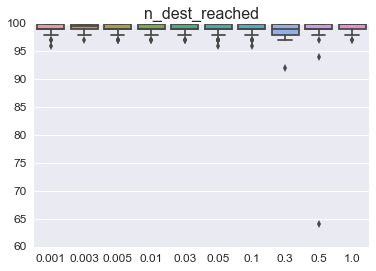

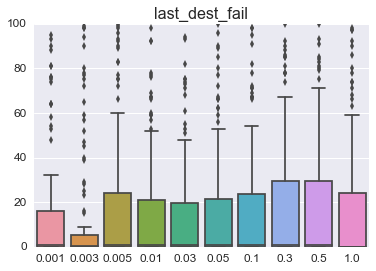

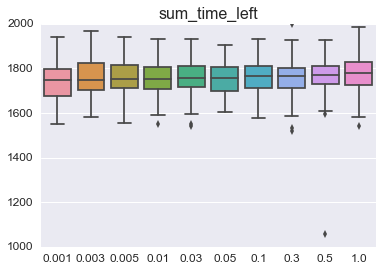

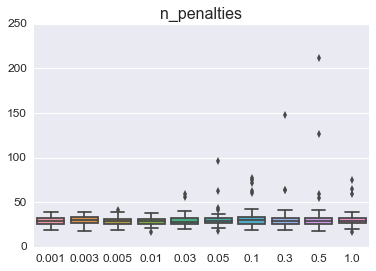

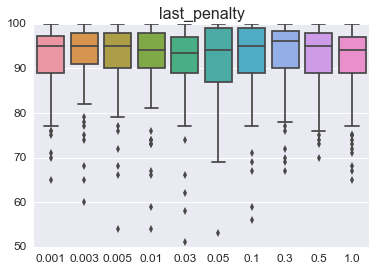

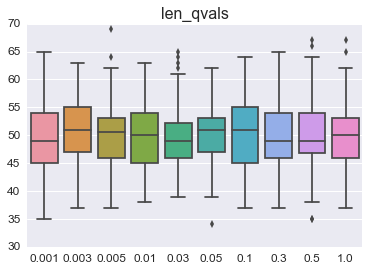

In [16]:
import pandas as pd

rate_panel = pd.Panel.from_dict(learning_rate_results)
for column in df_learning.columns:
    sns.boxplot(data=rate_panel.minor_xs(column))
    plt.title(column)
    plt.show()
    plt.close()

My posterior is very close to my prior: for this agent, tweaking the learning rate doesn't do much. `last_penalty`, in particular, remains (on average) as high as it was before.

## Randomly Picking Actions

Another possibility to tweak the learning agent is making it pick actions at random from time to time. The following `best_action()` function does just that:

In [17]:
def best_action(self, state):
    """
    Returns the best action (the one with the maximum Q-value)
    or a random action
    """
    # get the rate of random values at this point in time
    random_rate = 1.0 - self.time * self.eps

    # if random number smaller than random rate, 
    # the agent picks an unexplored action at the current state
    if random.random() < random_rate:
        unexplored_actions = [action for action in self.possible_actions
                              if (state, action) not in self.qvals.keys()]
        if unexplored_actions:
            actions = unexplored_actions
        else: # if no actions are unexplored in this state, pick any action
            actions = self.possible_actions

    else:
        # get all possible q-values for the state
        all_qvals = {action: self.qvals.get((state, action), 0)
                     for action in self.possible_actions}        

        # pick the actions that yield the largest q-value for the state
        actions = [action for action in self.possible_actions 
                   if all_qvals[action] == max(all_qvals.values())]

    # return one of the actions at random
    return random.choice(actions)

(When picking at random, the agent will pick, if possible, an action that hasn't been performed yet given the state. This increases the exploratory nature of the agent somewhat.)

The larger `random_rate`, the more probable it is that the agent will pick an action at random. `eps` is the variable that governs how fast this probability drops, much like `mult` governed how fast the learning rate would drop in the implementation above. 

Note that at some point `self.time * self.eps` will be larger than 1, and `random_rate` will drop below zero, meaning it will be impossible for the agent to pick an action at random. The idea is that at some point the agent will end its exploratory activity completely, and dedicate itself to exploiting what it's learned. It is possible to modify the formula for `random_rate` so that a small chance of randomness remains (using something like the formula for `learn_rate` in the previous implementation), but I think once the agent has explored enough it should revert to a fully exploitative mode. 

I ran several simulations with different values for `eps` using pretty much the same code as the one to vary learning rates:

In [18]:
def several_random_changes(epses, folder):
    """
    For each eps value in epses, runs a simulation
    with a LearningRandomAgent.
    Returns a dict with dataframe results for the agent
    for each eps value.
    """
    results = {}
    for eps in epses:
        eps_results = []
        for i in range(100):
            sim_results = run_random_change(eps)
            eps_results.append(sim_results)
        df_results = pd.DataFrame(eps_results)
        df_results.columns = ['n_dest_reached', 'last_dest_fail', 
                              'sum_time_left', 'n_penalties',
                              'last_penalty', 'len_qvals']
        df_results.to_csv("{}/random_rate_{}_results.csv".format(folder, eps))
        results[eps] = df_results
    return results

The code for learning agents with probabilistically randomized behavior is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/learning_random_agent.py).

And here are the results:

In [19]:
from smartcab.learning_random_agent import several_random_changes

epses = [1, 0.5, 0.3, 0.1, 0.05, 0.03, 0.01, 0.005, 0.003, 0.001]

if 'random_learning' not in os.listdir('./agent_results'):
    os.mkdir('agent_results/random_learning')

with io.capture_output() as captured:
    learning_random_results = several_random_changes(epses, './agent_results/random_learning')

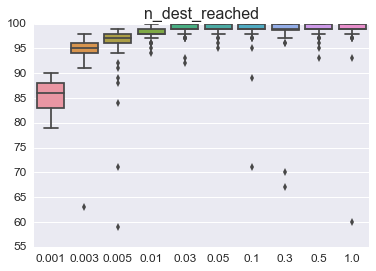

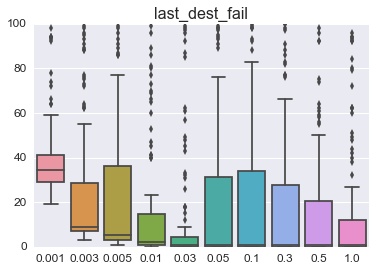

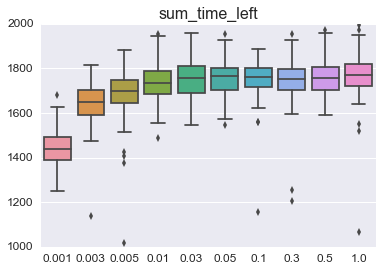

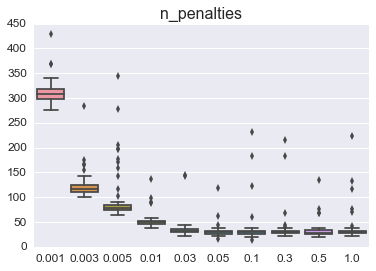

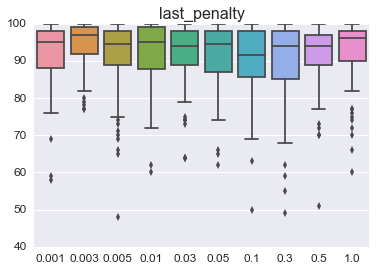

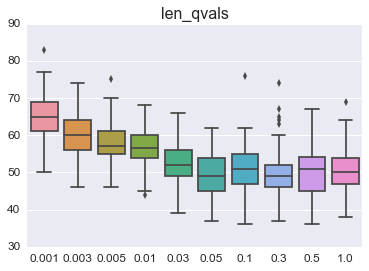

In [20]:
import pandas as pd

random_panel = pd.Panel.from_dict(learning_random_results)
for column in df_learning.columns:
    sns.boxplot(data=random_panel.minor_xs(column))
    plt.title(column)
    plt.show()
    plt.close()

Agents with a smaller `eps` (that is, a larger propensity to explore at random) perform clearly worse in terms of destinations reached and number of penalties. They do, however, tend to explore more of the state space. Which suggests that maybe the exploration-exploitation dilemma is not that large of an issue in this setting: the original learning agent is not very exploratory, but exploring more does not have a clear upside.

## Other Ideas

No modification of the original learning agent is clearly better than it - and in fact it seems like, on the contrary, my original agent is better than all of the other possibilities analyzed. Given that the original learning agent had results comparable to those of a perfect agent, this is not very surprising.

However, there may be some room for improvement in other areas:

- Improve the planner. Even a perfect agent, defined as one that follows the planner's recommendation whenever possible, sometimes fails to reach its destination. A better planner could mean less mistakes for the agents.
- Increase the number of trials. Even when the agent picks actions completely at random, a large number of `(state, action)` pairs remains unexplored, suggesting some states may come up only rarely. With a larger number of trials, more of the state space can be explored. This could solve the problem of the learning agent still receiving penalties even in the last trials.
- Increase the number of other cars in the simulation. Maybe one reason why some states are so rare is the small number of cars on the streets. With more cars, it would be more likely to see full intersections, for instance. As it is now, I believe most of the time there are only one or two cars per intersection, and some states come up only rarely.


## Project Rubric Rundown

Let's quickly review the [project rubric](https://review.udacity.com/#!/rubrics/106/view) and fill any remaining gaps:



- Implement a basic driving agent
    - Agent accepts inputs
    - Produces a valid output
    - Runs in simulator
- Identify and update state
    - Reasonable states identified
    - Agent updates state
	
The tasks above were implemented in the basic agent (code [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/basic_agent.py)). The states were identified and discussed in the section "Task 2: Identify and Update State" above.

- Implement Q-Learning
    - Agent updates Q-values
    - Picks the best action
    - Given the current set of Q-values for a state, it picks the best available action.
    - Changes in behavior explained

The tasks above were implemented in the learning agent (code [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/learning_agent.py)). The changes between agentes were presented in tables along the report. To summarize, the basic agent merely drives at random, and only reaches its destination by accident; while the learning agent presents a similar erratic beahvior at the beginning of the simulation but quickly starts aiming for the destination, indicating it is learning to pick as action the next waypoint. It also learns to avoid illegal moves as time goes by.

- Enhance the driving agent
    - Agent learns a feasible policy within 100 trials
    - Improvements reported
    - Final agent performance discussed

The original learning agent from the previous step was already able to learn a feasible policy within 100 trials, getting results that were close to a perfect agent's, as discussed above. I tried to tweak some parameters to improve the main problem with my learning agent (frequently getting late penalties), but none of the changes implemented were of help. These modifications include [optimism in the face of uncertainty](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/optimistic_agent.py), [modified learning rates](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/rate_change_agent.py) and [occasional random actions](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/learning_random_agent.py).

My final agent (code [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/agent.py)) is actually the first agent I came up with, tweaked a little bit to print out information regarding penalties incurred. It gets very close to the perfect agent in terms of number of reaching its destination, but incurs in much more penalties, and occasionally is penalized in late trials. I believe this could be fixed by either increasing the number of trials (i.e., extending the learning period) or the number of cars in the world, so that more `(state, action)` pairs would be visited by the agent.

As stated and above and coded [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/perfect_agent.py), the perfect agent is one that always picks `next_waypoint` as its action and obey traffic rules - that is, it's an agent whose action is always either `next_waypoint` or, when said action cannot be performed, `None`.

## Answering the Reviewer's Comments

The reviewer of my last submission asked for more information regarding my agent's behavior:

> You state "It gets very close to the perfect agent in terms of number of reaching its destination, but incurs in much more penalties, and occasionally is penalized in late trials." As this is a good start here, thus can you provide some justification for this based on the observing the agent behavior. As what is happening in the occasional penalized in the late trial? Is is running a red light? Etc...

> Some other ideas

> - in the last ten trials does the agent always follow the rules of the road? If not under what specific circumstances does it disobey traffic laws?
> - does the agent always try to go the shortest path to the final destination or go around in circles, go an indirect route?
> - provide some evidence, such as examining the Q-table

The evidence I chose to provide is a log of the penalties incurred by the agent in a given simulation with 100 trials, which can be found [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/penalty_logs/penalty_log.txt). The file also informs whether the agent reached its destination in each trial. When a penalty occurs, the state the agent was in, the number of times that state has been visited by action, the action taken by the agent and the penalty it received are reported.

Let's take a look at the beginning of the file to have an idea of what it's telling us:

In [21]:
import re

pen_log = "penalty_logs/penalty_log.txt"

with open(pen_log, 'r') as f:
    string = f.read()

print re.findall("^(.*?)Simulator.run\(\): Trial 2", string, re.DOTALL)[0]

Simulator.run(): Trial 0

penalty!
light: green, oncoming: None, left: None, waypoint: right
visit number 1 to state
action: left
reward: -0.5


penalty!
light: red, oncoming: None, left: None, waypoint: right
visit number 2 to state
action: forward
reward: -1.0


penalty!
light: red, oncoming: None, left: None, waypoint: right
visit number 4 to state
action: left
reward: -1.0


penalty!
light: green, oncoming: None, left: None, waypoint: forward
visit number 1 to state
action: right
reward: -0.5


penalty!
light: red, oncoming: None, left: None, waypoint: left
visit number 2 to state
action: left
reward: -1.0


penalty!
light: green, oncoming: None, left: None, waypoint: left
visit number 1 to state
action: forward
reward: -0.5


penalty!
light: green, oncoming: None, left: None, waypoint: left
visit number 3 to state
action: right
reward: -0.5


penalty!
light: red, oncoming: None, left: None, waypoint: forward
visit number 1 to state
action: left
reward: -1.0


penalty!
light: green

In the example above, there are 11 penalties in trial 0, but the agent still reaches its destination at this trial. In trial 1, the agent reaches its destination without incurring any penalties.

The function below programatically analyzes the penalty log and returns three lists containing the following information for each trial:
- whether the destination was reached
- the number of penalties incurred during the trial
- the number of penalties incurred during the trial when there was no traffic in the intersection

In [22]:
import re

def analyze_penalty_log(penalty_log):
    with open(penalty_log, 'r') as f:
        string = f.read()
        
    trials = [patterns[0] for patterns in
              re.findall(r'(Trial \d{1,2}.*?)(Simulator|$)', 
                         string, re.DOTALL)]

    dest_reached = [len(re.findall('reached destination', trial))
                    for trial in trials]

    penalties = [len(re.findall('penalty!', trial)) for trial in trials]

    penalties_no_traffic = [len(re.findall('oncoming: None, left: None',
                                           trial))
                            for trial in trials]
    
    print "number of destinations reached: ", sum(dest_reached)
    if sum(dest_reached) != 100:
        print "last unreached destination: trial", max([i for i in range(len(dest_reached)) 
                                                        if not dest_reached[i]])
    print "total number of penalties: ", sum(penalties)
    print "penalties during first 50 trials:", sum(penalties[:50])
    print "total number of penalties on clear intersections:", sum(penalties_no_traffic)
    print "last penalty on clear intersection:", max([i for i in range(len(penalties_no_traffic)) 
                                                      if penalties_no_traffic[i]])

The function can be found [here](). CHANGECHANGE

Let's see the results for the penalty log presented above:

In [23]:
analyze_penalty_log(pen_log)

number of destinations reached:  100
total number of penalties:  40
penalties during first 50 trials: 28
total number of penalties on clear intersections: 13
last penalty on clear intersection: 6


In the simulation analyzed, the agent reaches its destination in all trials and incurs in 40 penalties overall, of which 28 happen in the first 50 trials. Only 13 penalties happen when there is no traffic oncoming nor to the left of the agent, and the last of these penalties happens in the seventh trial. 

This seems to support the idea presented above that the small number of cars in the road affects the learning progress of the agent: late penalties occur when the agent finds itself in an intersection with other cars, an occurrence rare enough that the agent does not have the time, over 100 trials, to fully learn how to behave when it happens. More cars in the road should make the agent bump into such situations more often, and learn faster what to do then.

However, the penalty log of another simulation (file [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/penalty_logs/penalty_log2.txt)) told a very different story:

In [24]:
pen_log_2 = 'penalty_logs/penalty_log2.txt'
analyze_penalty_log(pen_log_2)

number of destinations reached:  97
last unreached destination: trial 96
total number of penalties:  101
penalties during first 50 trials: 53
total number of penalties on clear intersections: 82
last penalty on clear intersection: 99


In this simulation there were 101 penalties, only 53 of which happened during the first 50 trials. 82 of all penalties happened with no traffic oncoming nor to the left of the agent.

Let's see what the other conditions were (the light and the waypoint) in the situations in which the intersection was clear for the agent:

In [25]:
from collections import Counter

with open(pen_log_2, 'r') as f:
    string = f.read()

events = re.findall(r'light: (red|green), oncoming: None, left: None, waypoint: (forward|left|right)', string)
Counter(events)

Counter({('green', 'left'): 1,
         ('green', 'right'): 73,
         ('red', 'forward'): 3,
         ('red', 'left'): 3,
         ('red', 'right'): 2})

73 ot the 82 penalties incurred in clear intersections happened when the light was green and the agent was supposed to go right. What was the agent's action in these situations?

In [26]:
actions = re.findall(r'light: green, oncoming: None, left: None, waypoint: right.*?action: (\w*)', string, re.DOTALL)
Counter(actions)

Counter({'left': 73})

The agent thinks the best action in this situation is to go left. With a green light and no oncoming traffic, this is a legal move, so the agent would perform the action but incur a -0.5 penalty for not following the planner.

I'm note sure, but I think what happened in this simulation is something I mentioned as a possibility in the section about agents with different learning rate decays. My theory is that, due to a flaw in the planner, the agent at some point is told to go right when the destination is immediately to its left. The agent randomly takes a left and gets a -0.5 penalty - but it also gets a 10.0 reward for reaching its destination! So the perceived reward for this move - going left when the planner is saying right - is 9.5, large enough that, depending on the learning rate decay, small penalties happening later in the game won't change the agent's opinion about which is the best action.

As for the agent's behavior, it tends to go straight for the destination, with two exceptions I could notice:

- The agent seems to ignore that it lives in a toroidal world - that is, that going South at the southernmost position would bring it to the northernmost position, and so on. This makes the agent take more time than it could to reach its destination sometimes.
- Sometimes the agent will take a strange U-turn that involves distancing itself from the destination. For instance, when the destination is to the Southeast of the agent and the agent is facing West, it will sometimes turn right to make a U-turn, going North instead of South.

## Bonus 1: Changing the State Space

As mentioned above, I [checked on the Udacity forum](https://discussions.udacity.com/t/i-dont-know-if-this-idea-is-a-kind-of-cheating/170894/19) and I'm not allowed to do this. But what if I were to work on the inputs before passing them to the Q-learning function? 

In [27]:
def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)

    # update time and learning rate
    self.time += 1

    ok_forward = (inputs['light'] == 'green')
    ok_right = (inputs['light'] == 'green') or (inputs['left'] != 'forward')
    ok_left = all([inputs['light'] == 'green',
                   inputs['oncoming'] != 'forward',
                   inputs['oncoming'] != 'right'])

    # Update state
    self.state = (ok_forward, ok_right, ok_left, self.next_waypoint)

    # Pick the best known action
    action = self.best_action(self.state)

    # Execute action and get reward
    reward = self.env.act(self, action)
    if reward < 0:
        self.n_penalties += 1

    # Update the q-value of the (state, action) pair
    self.update_qvals(self.state, action, reward)

The code for this agent is [here](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/new_state_agent.py).

Now each state is a tuple with 4 values: whether it's okay to go forward, turn right, or turn left (2 options each), and the next waypoint (3 possibilities). Multiplying this by 4 possible actions, we have a slim 96 possible `(state, action)` pairs.

In [28]:
from smartcab.new_state_agent import NewStateAgent

with io.capture_output() as captured:
    df_new_state = run_sims(100, 100, NewStateAgent)
df_new_state.describe()

,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,99.270000,9.990000,1771.060000,16.300000,63.780000,21.97000
std,2.549926,24.351589,81.450589,19.054149,30.894928,2.94205
min,75.000000,0.000000,1386.000000,8.000000,2.000000,16.00000
25%,99.000000,0.000000,1726.750000,11.000000,42.750000,20.00000
50%,100.000000,0.000000,1769.500000,12.000000,73.000000,22.00000
75%,100.000000,1.000000,1819.750000,14.000000,90.000000,24.00000
max,100.000000,95.000000,1948.000000,150.000000,100.000000,31.00000


Alright, now `last_penalty` is significantly down, and the number of destinations reached remains similar to the original learning agent. Let's visualize how this implementation compares to the original learning agent, the optimistic one and the perfect one:

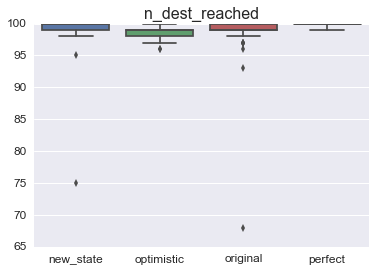

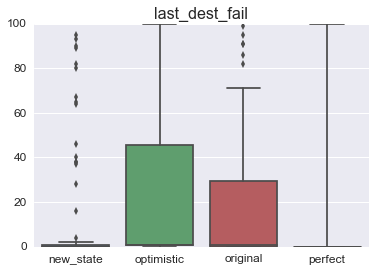

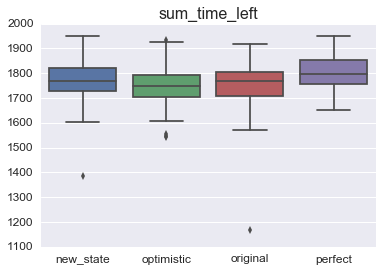

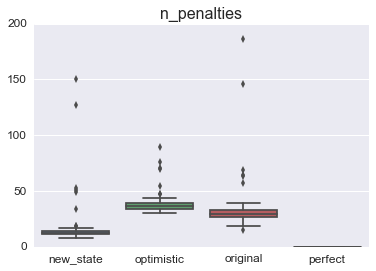

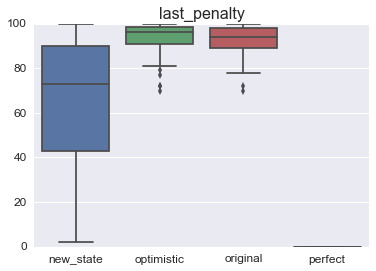

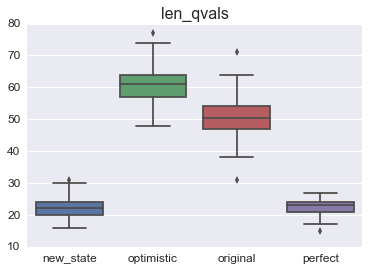

In [29]:
results = {'original': df_learning,
           'optimistic': df_optimistic,
           'new_state': df_new_state,
           'perfect': df_perfect}

final_panel = pd.Panel.from_dict(results)
for column in df_learning.columns:
    sns.boxplot(data=final_panel.minor_xs(column))
    plt.title(column)
    plt.show()
    plt.close()

That's a clear improvement across the board, with a far simpler state space.

Is this cheating? Maybe. But imagine you're trying to use reinforcement learning to teach a program to play chess. I think it's fair to say you would hardcode how the pieces move and then let the learner play, instead of making it first figure out that pawns can't move back and bishops only move diagonally. So, it's reasonable to expect the rules of the game will be known in advance - and I'm not even doing that: I'm just passing a simpler state for the agent's Q-learning function, but it still needs to figure out how this state applies. So this might be fair game after all.

## Bonus 2: Improving the Planner

Let's see how the four main agents presented above - the original learning agent, the optimistic agent, the agent with a simpler state space, and the perfect agent - fare when taking waypoints from an [improved planner](https://github.com/lmurtinho/machine-learning/blob/my_projects/projects/smartcab/smartcab/perfect_planner.py) I came up with.

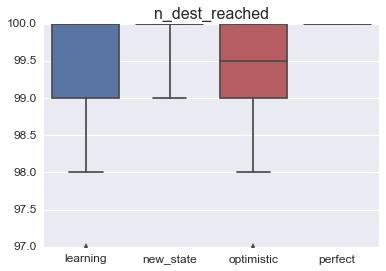

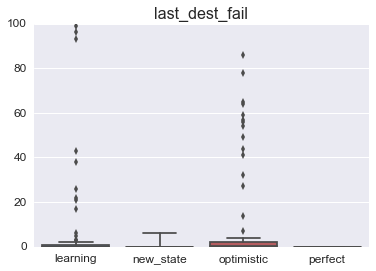

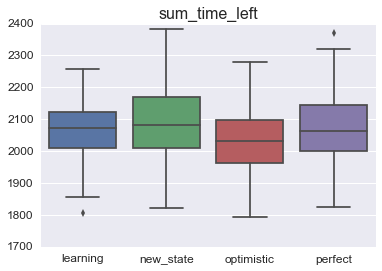

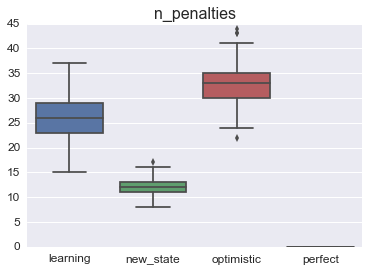

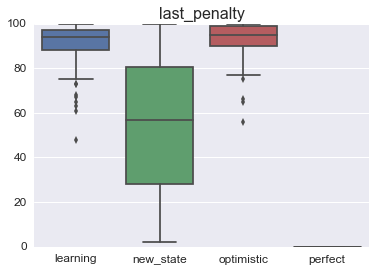

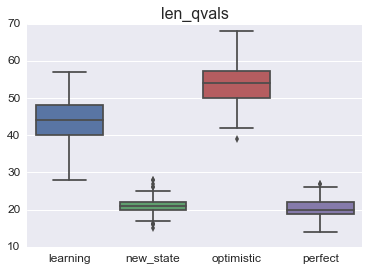

In [30]:
from smartcab.run_perfect import run_sims

agents = {'learning': LearningAgent,
          'optimistic': OptimisticAgent,
          'new_state': NewStateAgent,
          'perfect': PerfectAgent}

dfs = {}

for agent in agents:
    with io.capture_output() as captured:
        dfs[agent] = run_sims(100, 100, agents[agent])

perfect_planner_panel = pd.Panel.from_dict(dfs)
for column in df_learning.columns:
    sns.boxplot(data=perfect_planner_panel.minor_xs(column))
    plt.title(column)
    plt.show()
    plt.close()

Now the perfect agent reaches its destination every time - but the other agents' performance also improved, and none of them fail to reach their destinations more than twice in any given simulation. And these rare failures tend to occur earlier than they did with the original planner. 

The number of penalties - or at least the number of simulations with large number of penalties - also decreases, but the problem of late last penalties persists. As mentioned above, an environment with more cars may help with this, by forcing the smartcab to explore more of the state space in the same number of trials. Or maybe there could be a way of adapting the agent's `best_action` method to select actions based on neighboring states whenever the state has never been visited before. These are modifications that could further improve the agent.  